### Plan of Attack <br>
#### Web-scrape signals from the git repo
#### Also webscrape daily bitcoin price action
#### Scale and Standardize important features
#### Build out the EMA, DEMA and TEMA technical signals 
#### For aa 7 day forward looking model, change target value to be 7 days after the current date (sounds like a rotate/shift approach for this use-case

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import quandl
import investpy

In [2]:
def webscraping_helper(URL,col_name,join_df,join=True,check_column=True,check_URL = True,clear_URL_array=False,show_details=False):
    '''This function scraps the given link and returns dataframe
    __________
    Parameters:
        URL(string): URL to be scrapped from bitcoin website
        col_name(string): column name for dataframe
        join_df(variable)= dataframe withwhich output dataframe will be left joined on Date
        join(boolean)= iF True,join, else don't join
        check_column(boolean)= check if column name already exists
        check_URL(boolean)= check if URL is already processed
        clear_URL_array(boolean)= if true URL_processed array will be cleared
        show_details(boolean)= various details wil be printed such as scrapping first and last details, df head & df tail     
        '''
        
    print(f'processing {col_name}')

    #clear URL append array
    if clear_URL_array==True:
        URL_array.clear()

    #set join parameters if false
    if join == False:
        join_df = None
        check_column=False

    #process column name by making it lowercase and replacing spaces,commas, full stops
    col_name = col_name.lower().replace(',','').replace(" ", "_").replace(".", "_")

    #col_name validation if exists already
    if check_column==True and col_name in list(join_df.columns):
        print(f'column {col_name} already esists in dataframe, stopped here')
        return join_df

    #web scrapping
    page = requests.get(URL)
    soup = page.content
    soup = str(soup)
    scraped_output = (soup.split('[[')[1]).split('{labels')[0][0:-2]
    if show_details == True:
        print('head')
        print({scraped_output[0:30]})
        print('tail')
        print({scraped_output[-30:]})

    processed_str = scraped_output.replace('new Date(','')
    processed_str = processed_str.replace(')','')
    processed_str = processed_str.replace('[','')
    processed_str = processed_str.replace(']','')
    processed_str = processed_str.replace('"','')

    processed_str_list = processed_str.split(',')
    date_list,data_list = processed_str_list[::2],processed_str_list[1::2]

    #validate column lengths
    if len(date_list)!=len(data_list):
        print(f'date & data length:{len(date_list),len(data_list),len(date_list)==len(data_list)}')
        
    if col_name not in list(join_df.columns) and join == True:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        join_df = pd.merge(join_df,df,on=['Date'],how='left')
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'output df shape= {df.shape},joined_df shape = {join_df.shape}')
            print('='*100)
            print(f'Number of duplicate columns in dataframe {df.columns.duplicated().sum()}')
            print('='*100)
    
        return join_df

In [3]:
btc_df = investpy.get_crypto_historical_data(crypto='bitcoin',from_date='01/01/2013',to_date='09/02/2022')
btc_df = btc_df.reset_index()
btc_df.drop(['Currency','Volume'],inplace=True,axis=1)
btc_df.columns = ['Date','opening_price','highest_price','lowest_price','closing_price']
btc_df.head()

,Date,opening_price,highest_price,lowest_price,closing_price
0,2013-01-01,13.5,13.6,13.2,13.3
1,2013-01-02,13.3,13.4,13.2,13.3
2,2013-01-03,13.3,13.5,13.3,13.4
3,2013-01-04,13.4,13.5,13.3,13.5
4,2013-01-05,13.5,13.6,13.3,13.4


In [4]:
from collections import defaultdict
scraping_lookup = defaultdict()

In [5]:
scraping_lookup['transactions in blockchain'] = 'https://bitinfocharts.com/comparison/bitcoin-transactions.html'
scraping_lookup['avg block size'] = 'https://bitinfocharts.com/comparison/size-btc.html'
scraping_lookup['sent by adress'] = 'https://bitinfocharts.com/comparison/sentbyaddress-btc.html'
scraping_lookup['avg mining difficulty'] = 'https://bitinfocharts.com/comparison/bitcoin-difficulty.html'
scraping_lookup['avg hashrate'] = 'https://bitinfocharts.com/comparison/bitcoin-hashrate.html'
scraping_lookup['mining profitability'] = 'https://bitinfocharts.com/comparison/bitcoin-mining_profitability.html'
scraping_lookup['Sent coins in USD'] = 'https://bitinfocharts.com/comparison/sentinusd-btc.html'
scraping_lookup['avg transaction fees'] = 'https://bitinfocharts.com/comparison/bitcoin-transactionfees.html'
scraping_lookup['median transaction fees'] = 'https://bitinfocharts.com/comparison/bitcoin-median_transaction_fee.html'
scraping_lookup['avg block time'] = 'https://bitinfocharts.com/comparison/bitcoin-confirmationtime.html'
scraping_lookup['avg transaction value'] = 'https://bitinfocharts.com/comparison/transactionvalue-btc.html'
scraping_lookup['median transaction value'] = 'https://bitinfocharts.com/comparison/mediantransactionvalue-btc.html'
# scraping_lookup['tweets'] = 'https://bitinfocharts.com/comparison/tweets-btc.html'
scraping_lookup['google trends'] = 'https://bitinfocharts.com/comparison/google_trends-btc.html'
scraping_lookup['active addresses'] = 'https://bitinfocharts.com/comparison/activeaddresses-btc.html'
scraping_lookup['top100 to total percentage'] = 'https://bitinfocharts.com/comparison/top100cap-btc.html'
scraping_lookup['avg fee to reward'] = 'https://bitinfocharts.com/comparison/fee_to_reward-btc.html'

In [6]:
scraping_lookup

defaultdict(None,
            {'transactions in blockchain': 'https://bitinfocharts.com/comparison/bitcoin-transactions.html',
             'avg block size': 'https://bitinfocharts.com/comparison/size-btc.html',
             'sent by adress': 'https://bitinfocharts.com/comparison/sentbyaddress-btc.html',
             'avg mining difficulty': 'https://bitinfocharts.com/comparison/bitcoin-difficulty.html',
             'avg hashrate': 'https://bitinfocharts.com/comparison/bitcoin-hashrate.html',
             'mining profitability': 'https://bitinfocharts.com/comparison/bitcoin-mining_profitability.html',
             'Sent coins in USD': 'https://bitinfocharts.com/comparison/sentinusd-btc.html',
             'avg transaction fees': 'https://bitinfocharts.com/comparison/bitcoin-transactionfees.html',
             'median transaction fees': 'https://bitinfocharts.com/comparison/bitcoin-median_transaction_fee.html',
             'avg block time': 'https://bitinfocharts.com/comparison/bitcoi

In [7]:
for scraping_name in scraping_lookup:
    btc_df = webscraping_helper(scraping_lookup[scraping_name], scraping_name, join_df=btc_df, join=True)

processing transactions in blockchain
processing avg block size
processing sent by adress
processing avg mining difficulty
processing avg hashrate
processing mining profitability
processing Sent coins in USD
processing avg transaction fees
processing median transaction fees
processing avg block time
processing avg transaction value
processing median transaction value
processing tweets
processing google trends
processing active addresses
processing top100 to total percentage
processing avg fee to reward


In [8]:
btc_df.head()

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_fees,median_transaction_fees,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,0.0107,0.0067,8.889,625.432,14.518,NaN,1.194,37846,19.536,0.627
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,0.0108,0.0066,9.412,650.617,14.514,NaN,1.497,43104,19.597,0.835
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,0.0118,0.00661,8.889,542.73,19.732,NaN,1.798,51268,19.621,0.925
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,0.0105,0.00661,9.412,632.431,11.384,NaN,1.841,47341,19.54,1
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,0.0105,0.00659,10.213,697.556,13.945,NaN,1.826,53417,19.543,0.885


In [9]:
btc_circulation_df = quandl.get("BCHAIN/TOTBC",authtoken='9ztFCcK4_e1xGo_gjzK7')
btc_circulation_df = btc_circulation_df.rename(columns={'Value': 'number_of_coins_in_circulation'})

In [10]:
btc_circulation_df

,number_of_coins_in_circulation
Date,
2009-01-02,50.00
2009-01-03,50.00
2009-01-04,50.00
2009-01-05,50.00
2009-01-06,50.00
...,...
2022-02-08,18952443.75
2022-02-09,18953325.00
2022-02-10,18954200.00


In [11]:
miner_revenue_df = quandl.get("BCHAIN/MIREV",authtoken='9ztFCcK4_e1xGo_gjzK7')
miner_revenue_df = miner_revenue_df.rename(columns={'Value': 'miner_revenue'})

In [12]:
btc_onchain_df = pd.merge(btc_df,btc_circulation_df,on=['Date'],how='inner')
btc_onchain_df = pd.merge(btc_onchain_df,miner_revenue_df,on=['Date'],how='inner')
btc_onchain_df.head()

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,8.889,625.432,14.518,NaN,1.194,37846,19.536,0.627,10621175.0,52648.600000
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,9.412,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.0,54865.251543
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,8.889,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.0,48118.330620
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,9.412,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.0,50872.740000
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,10.213,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.0,51396.725494


In [13]:
btc_onchain_df.columns

Index(['Date', 'opening_price', 'highest_price', 'lowest_price',
       'closing_price', 'transactions_in_blockchain', 'avg_block_size',
       'sent_by_adress', 'avg_mining_difficulty', 'avg_hashrate',
       'mining_profitability', 'sent_coins_in_usd', 'avg_transaction_fees',
       'median_transaction_fees', 'avg_block_time', 'avg_transaction_value',
       'median_transaction_value', 'tweets', 'google_trends',
       'active_addresses', 'top100_to_total_percentage', 'avg_fee_to_reward',
       'number_of_coins_in_circulation', 'miner_revenue'],
      dtype='object')

In [14]:
btc_onchain_df['next_week_closing_price'] = btc_onchain_df['closing_price'].shift(-7)

In [15]:
missing_values = pd.DataFrame(btc_onchain_df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
tweets,463
next_week_closing_price,7
google_trends,5
median_transaction_fees,0
miner_revenue,0
number_of_coins_in_circulation,0
avg_fee_to_reward,0
top100_to_total_percentage,0
active_addresses,0
median_transaction_value,0


In [32]:
btc_onchain_df.replace(to_replace='null', value=np.nan,inplace=True)
btc_onchain_df.drop(btc_onchain_df.tail(1).index,inplace=True)
btc_onchain_df.head()

,Date,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,mining_profitability,sent_coins_in_usd,avg_transaction_fees,median_transaction_fees,...,active_addresses,top100_to_total_percentage,avg_fee_to_reward,miner_revenue,number_of_coins_in_circulation,opening_price,highest_price,lowest_price,closing_price,next_week_closing_price
0,2013-01-01,31734,89033,26174,2979637,24331539528899,2246,18839472,0.0107,0.0067,...,37846,19.536,0.627,52648.600000,10621175.0,13.5,13.6,13.2,13.3,13.7
1,2013-01-02,39280,114077,31809,2979637,22804647966378,2233,23851896,0.0108,0.0066,...,43104,19.597,0.835,54865.251543,10621575.0,13.3,13.4,13.2,13.3,13.8
2,2013-01-03,42147,108023,38197,2979637,23724885599725,2276,20921297,0.0118,0.00661,...,51268,19.621,0.925,48118.330620,10628700.0,13.3,13.5,13.3,13.4,14.1
3,2013-01-04,48436,141811,34990,2979637,22608181137438,2259,29527613,0.0105,0.00661,...,47341,19.54,1,50872.740000,10632425.0,13.4,13.5,13.3,13.5,14.1
4,2013-01-05,39455,118240,38008,2979637,22590695489434,2074,26851599,0.0105,0.00659,...,53417,19.543,0.885,51396.725494,10633200.0,13.5,13.6,13.3,13.4,14.2


### Section: Exploratory Data Analysis

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.stats as st
import matplotlib.patches as mpl_patches
from scipy.stats import describe
import matplotlib.cm as cm
import matplotlib.lines as mlines
from scipy.stats import pearsonr

In [33]:
btc_onchain_df = btc_onchain_df = btc_onchain_df[['Date','transactions_in_blockchain','avg_block_size','sent_by_adress',
                                            'avg_mining_difficulty','avg_hashrate','mining_profitability',
                                            'sent_coins_in_usd','avg_transaction_fees','median_transaction_fees',
                                            'avg_block_time','avg_transaction_value','median_transaction_value',
                                            'tweets','google_trends','active_addresses','top100_to_total_percentage','avg_fee_to_reward',
                                            'miner_revenue','number_of_coins_in_circulation','opening_price','highest_price','lowest_price',
                                            'closing_price','next_week_closing_price']].apply(pd.to_numeric)

In [34]:
btc_onchain_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3326 entries, 0 to 3325
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            3326 non-null   int64  
 1   transactions_in_blockchain      3326 non-null   int64  
 2   avg_block_size                  3326 non-null   int64  
 3   sent_by_adress                  3326 non-null   int64  
 4   avg_mining_difficulty           3326 non-null   int64  
 5   avg_hashrate                    3326 non-null   float64
 6   mining_profitability            3326 non-null   float64
 7   sent_coins_in_usd               3326 non-null   int64  
 8   avg_transaction_fees            3326 non-null   float64
 9   median_transaction_fees         3326 non-null   float64
 10  avg_block_time                  3325 non-null   float64
 11  avg_transaction_value           3326 non-null   float64
 12  median_transaction_value        33

In [35]:
def plot_data(df,feature_name,exclude_feature='next_week_closing_price'):
    random_color = (random.random(), random.random(), random.random())
    df.plot(x='Date',y=feature_name,figsize=(25,5),grid=True,color=random_color)
    plt.title(f'Date VS {feature_name.replace("_"," ")}')
    plt.ylabel(feature_name)
    plt.show()

    df.plot(kind='kde',y=feature_name,figsize=(25,5),grid=True,color=random_color)
    plt.title(f'KDE-{feature_name.replace("_"," ")}')
    plt.show()

    corr = df.corr().loc[[feature_name],:].sort_values(by=feature_name,axis=1).drop(columns=[feature_name,exclude_feature])
    plt.figure(figsize = (25,5))
    sns.heatmap(corr,cmap='tab10',square=True,annot=True,cbar=False,annot_kws={"fontsize":16},linewidths=1, linecolor='black',)
    plt.title(f'Correlation with other features')
    plt.show()
    
def plot_scatter(df,scatter_list,scatter_with):
    fig,axs = plt.subplots(1,len(scatter_list),sharey=False,figsize=(7*len(scatter_list),7))
    colors = plt.rcParams["axes.prop_cycle"]()
    for i,feat in enumerate(scatter_list):
        x = sorted(list(df[scatter_with]))
        y = sorted(list(df[feat]))

        axs[i].scatter(x,y,marker=".",color=next(colors)["color"],label=feat)

        line = mlines.Line2D([0, 1], [0, 1], color='black',linestyle=':',label='Normal Line')
        transform = axs[i].transAxes
        line.set_transform(transform)
        axs[i].add_line(line)
        axs[i].set_ylabel(feat)
        axs[i].grid()
        axs[i].set_xlabel(scatter_with)
        axs[i].legend()
    plt.show()

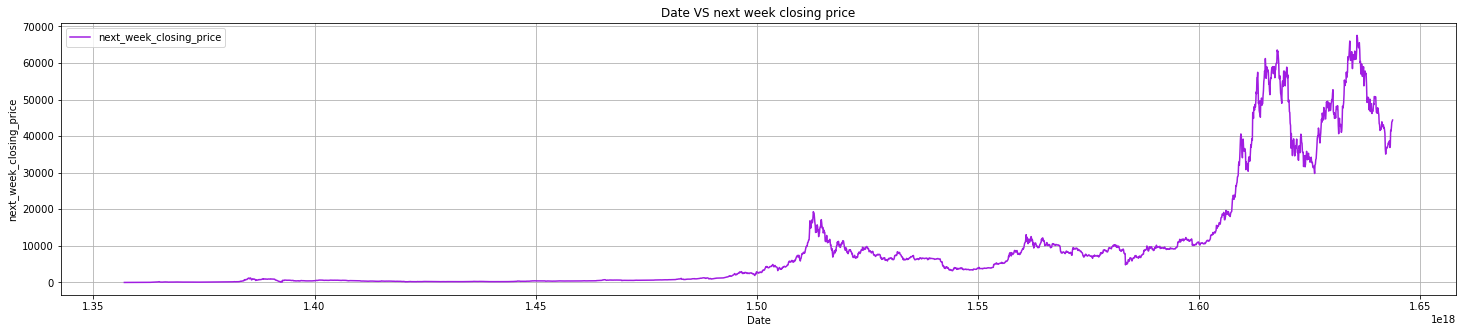

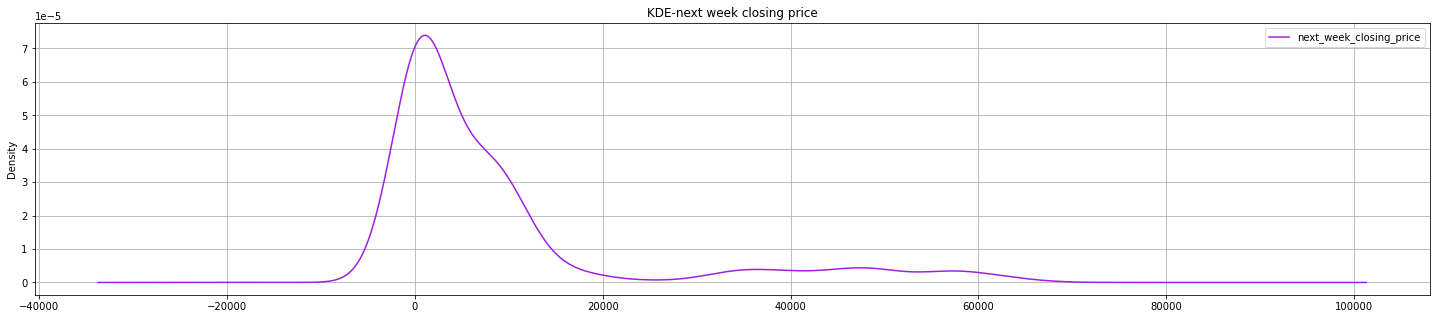

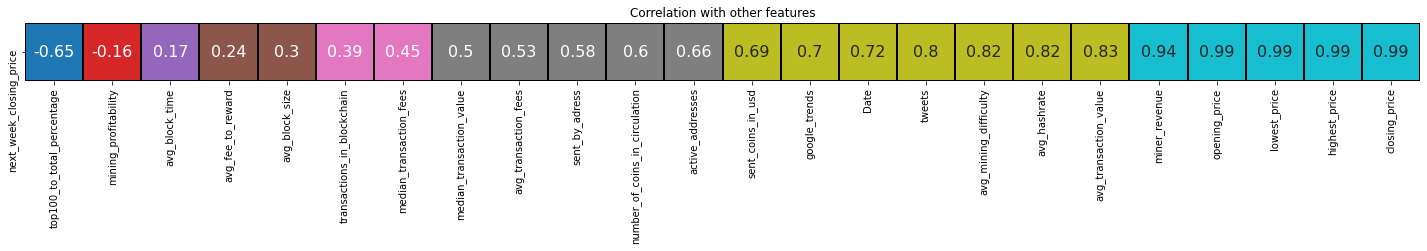

In [36]:
plot_data(btc_onchain_df,feature_name='next_week_closing_price')